In [1]:
%reset -fs

In [2]:
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Diamonds.csv', index_col=0)

In [4]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
_c0,,,,,,,,,,
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
996,0.54,Ideal,D,VVS2,61.4,52.0,2897,5.30,5.34,3.26
997,0.72,Ideal,E,SI1,62.5,55.0,2897,5.69,5.74,3.57
998,0.72,Good,F,VS1,59.4,61.0,2897,5.82,5.89,3.48


In [5]:
df.shape

(1000, 10)

In [6]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [7]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [8]:
df.cut.value_counts()

Ideal        333
Premium      290
Very Good    226
Good          89
Fair          62
Name: cut, dtype: int64

In [9]:
# Encode the ordinal categorical variable 'cut'
cut_mapping = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
df.cut = df.cut.map(cut_mapping)

In [10]:
df.color.value_counts()

E    240
F    226
G    139
D    129
H    125
I     95
J     46
Name: color, dtype: int64

In [11]:
# Encoding the ordinal categorical variable 'color'
color_mapping = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
df.color = df.color.map(color_mapping)

In [12]:
df.clarity.value_counts()

SI1     306
VS2     218
VS1     159
SI2     154
VVS2     62
VVS1     58
I1       29
IF       14
Name: clarity, dtype: int64

In [13]:
# Encoding the ordinal cateogircal variable 'clarity'
clarity_mapping = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
df.clarity = df.clarity.map(clarity_mapping)

In [14]:
df.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,0.689280,2.743000,3.640000,2.81200,61.722800,57.734700,2476.54000,5.605940,5.599180,3.457530
std,0.195291,1.186743,1.690934,1.51755,1.758879,2.467946,839.57562,0.625173,0.611974,0.389819
min,0.200000,0.000000,0.000000,0.00000,53.000000,52.000000,326.00000,3.790000,3.750000,2.270000
25%,0.700000,2.000000,2.000000,2.00000,60.900000,56.000000,2777.00000,5.640000,5.630000,3.450000
50%,0.710000,3.000000,4.000000,3.00000,61.800000,57.000000,2818.00000,5.770000,5.760000,3.550000
75%,0.790000,4.000000,5.000000,4.00000,62.600000,59.000000,2856.00000,5.920000,5.910000,3.640000
max,1.270000,4.000000,6.000000,7.00000,69.500000,70.000000,2898.00000,7.120000,7.050000,4.330000


In [15]:
df = df.drop(df[df["x"]==0].index)
df = df.drop(df[df["y"]==0].index)
df = df.drop(df[df["z"]==0].index)

In [16]:
df = df [df['depth'] < df['depth'].quantile(0.99)]
df = df [df['table'] < df['table'].quantile(0.99)]
df =df [df['x'] < df['x'].quantile(0.99)]
df  = df [df['y'] < df['y'].quantile(0.99)]
df  = df [df['z'] < df['z'].quantile(0.99)]

In [17]:
model_df = df.copy()

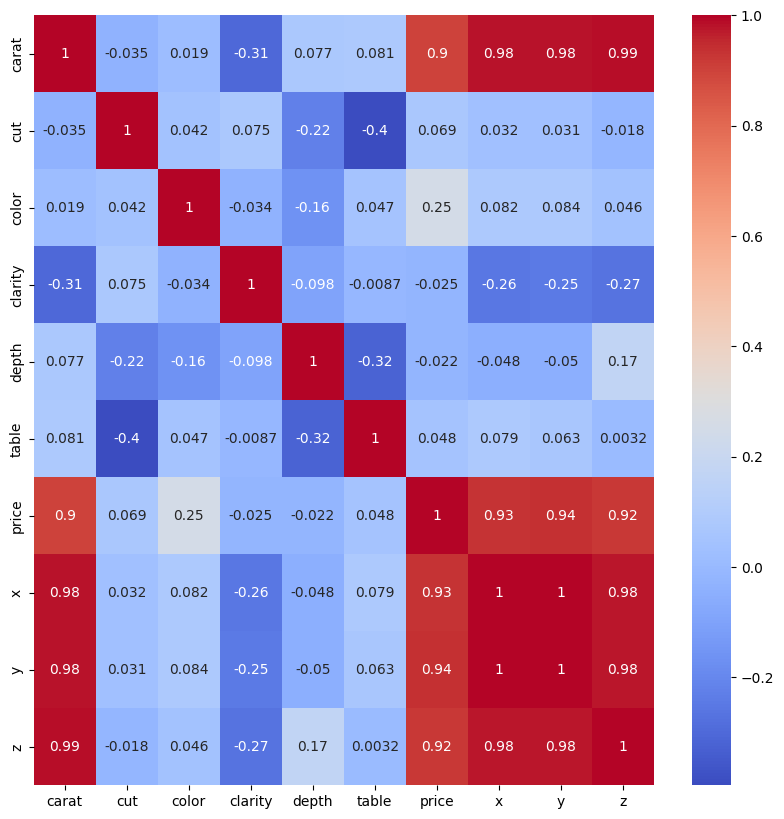

In [18]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(model_df.corr(), annot=True, cmap='coolwarm');

In [19]:
X = model_df.drop(['price'], axis=1)
y = model_df['price']

In [20]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

In [22]:
xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [.0001, 0.001, .01],
              'max_depth': [3, 5, 7],
              'min_child_weight': [3,5,7],
              'subsample': [0.1,0.5,1.0],
              'colsample_bytree': [0.1, 0.5, 1.0],
              'n_estimators': [500]}

In [23]:
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=0)

In [24]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.1, 0.5, 1.0],
                         'learning_rate': [0.0001, 0.001, 0.01],
                         'max_depth': [3, 5, 7], 'min_child_weight': [3, 5, 7],
                         'n_estimators': [500],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.1, 0.5, 1.0]})

In [25]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.9971426405203246
{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 1.0}


In [26]:
xgb_cv = (xgb_grid.best_estimator_)

In [32]:
eval_set = [(X_train, y_train),
            (X_val, y_val)]

In [33]:
fit_model = xgb_cv.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric='mae',
    early_stopping_rounds=50,
    verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [29]:
print("MAE:", mean_absolute_error(y_val, fit_model.predict(X_val)))
print("MSE:", mean_squared_error(y_val, fit_model.predict(X_val)))
print("R2:", r2_score(y_val, fit_model.predict(X_val)))

MAE: 39.52240921823602
MSE: 2229.406038994352
R2: 0.9971596525814765


In [30]:
print("MAE:", mean_absolute_error(y_test, fit_model.predict(X_test)))
print("MSE:", mean_squared_error(y_test, fit_model.predict(X_test)))
print("R2:", r2_score(y_test, fit_model.predict(X_test)))

MAE: 36.919421547337585
MSE: 2171.4971352790385
R2: 0.9968487366041291


In [31]:
fit_model.save_model('xgb_model.json')